# Testing the for the use of notebooks in the project! Dynamic models and so on


In [15]:
%pip install git+https://github.com/hallvar-h/tops

import sys
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol
from tops.dyn_models import blocks as blk
from tops.dyn_models import utils as utl
#from tops.ps_models import ieee39

  Cloning https://github.com/hallvar-h/tops to /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-h0uo9dve
  Running command git clone --filter=blob:none --quiet https://github.com/hallvar-h/tops /private/var/folders/8x/_s0cs76d26541h_f7wd81_n40000gn/T/pip-req-build-h0uo9dve
  Resolved https://github.com/hallvar-h/tops to commit 2daedbf4daca07d8c1e644d433a3fb27896ffbb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# AVR MODEL

Testing if a PSS model would work in a notebook with tops from pip

In [16]:
class AVR:
    def connections(self):
        return [
            {
                'input': 'v_t',
                'source': {
                    'container': 'gen',
                    'mdl': '*',
                    'id': self.par['gen'],
                },
                'output': 'v_t_abs',
            },
            {
                'input': 'v_setp',
                'source': {
                    'container': 'gen',
                    'mdl': '*',
                    'id': self.par['gen'],
                },
                'output': 'v_setp',
            },
            {
                'input': 'v_pss',
                'source': {
                    'container': 'gen',
                    'mdl': '*',
                    'id': self.par['gen'],
                },
                'output': 'v_pss',
            },
            {
                'output': 'output',
                'destination': {
                    'container': 'gen',
                    'mdl': '*',
                    'id': self.par['gen'],
                },
                'input': 'E_f',
            }
        ]


class SEXS_new(utl.DAEModel, AVR):
    def input_list(self):
        return ['v_setp', 'v_t', 'v_pss']

    def add_blocks(self):
        p = self.par
        self.tg_red = blk.LeadLag(T_1=p['T_a'], T_2=p['T_b'])
        self.gain = blk.Gain(K=p['K'])
        self.time_constant_lim = blk.TimeConstantLims(T=p['T_e'], V_min=p['E_min'], V_max=p['E_max'])
        self.tg_red.input = lambda x, v: self.v_setp(x, v) - self.v_t(x, v) + self.v_pss(x, v) + self.int_par['bias']
        self.gain.input = lambda x, v: self.tg_red.output(x, v)
        self.time_constant_lim.input = lambda x, v: self.gain.output(x, v)
        self.output = lambda x, v: self.time_constant_lim.output(x, v)

    def int_par_list(self):
        return ['bias']

    def init_from_connections(self, x0, v0, output_0):
        # auto_init(self, x0, v0, output_0['output'])
        self.int_par['bias'] = \
            self.tg_red.initialize(
                x0, v0, self.gain.initialize(
                    x0, v0, self.time_constant_lim.initialize(
                        x0, v0, output_0['output'])
            )
        )



# SYSTEM MODEL

Definition of system model below

In [17]:
def load_assignment_model():
    return {
        'base_mva': 50, #'base_mva': system base/nominal complex power in [MVA].
        'f': 50, #'f': system frequency in [Hz].
        'slack_bus': 'B3', #'slack_bus': reference busbar with zero phase angle.

        'buses': [
            ['name',    'V_n'],
            ['B1',         10],
            ['B2',        245],
            ['B3',        245],
        ],
        #'V_n': base/nominal voltage in [kV].

        'lines': [
            ['name',  'from_bus', 'to_bus',   'length',   'S_n',  'V_n',  'unit', 'R',    'X',   'B'],
            ['L2-3',        'B2',     'B3',        250,      50,    245,    'PF',   0,    0.4,     0],
        ],
        #'length': total line length in [km].
        #'S_n': base/nominal complex power in [MVA].
        #'V_n': base/nominal voltage in [kV].
        #'unit': chosen unit for jacobian admittance calculation (leave it as 'PF').
        #'R': line resistance in [Ohm/km].
        #'X': line reactance in [Ohm/km].
        #'B': line susceptance in [Ohm/km].

        'transformers': [
            ['name', 'from_bus', 'to_bus', 'S_n', 'V_n_from', 'V_n_to', 'R', 'X'],
            ['T1',         'B1',     'B2',    50,         10,      245,   0, 0.1],
        ],
        #'S_n': base/nominal complex power in [MVA].
        #'V_n_from': base/nominal voltage on the 'from_bus' side in [kV].
        #'V_n_to': base/nominal voltage on the 'to_bus' side in [kV].
        #'R': transformer resistance in [pu].
        #'X': transformer reactance in [pu].

        'loads': [
            ['name', 'bus', 'P', 'Q', 'model'],
            ['L1',    'B2',  25,   0,     'Z'],
        ],
        #'P': active power delivered to the load in [MW].
        #'Q': reactive power delivered to the load in [MVAr].
        #'model': modelling of load voltage dependence (leave it as 'Z').

        'generators': {
            'GEN': [
                ['name',   'bus',  'S_n',  'V_n',    'P',    'V',      'H',    'D',    'X_d',  'X_q',  'X_d_t',    'X_q_t',    'X_d_st',   'X_q_st',   'T_d0_t',   'T_q0_t',   'T_d0_st',  'T_q0_st'],
                ['G1',      'B1',     50,     10,     40,  0.933,      3.1,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
                ['IB',      'B3',    1e8,    245,    -15,  0.898,      1e5,      0,     1.05,   0.66,    0.328,      0.66,       0.254,      0.273,       2.49,      10000,         0.06,       0.15],
            ],
        },
        # For 'IB': change only 'V_n', 'P' and 'V' if necessary. Other parameters should be left as they are.

        # 'S_n': base/nominal complex power in [MVA].
        # 'V_n': base/nominal voltage in [kV].
        # 'P': active power produced by the generator in [MW].
        # 'V': magnitude of generator terminal voltage in [pu].
        # 'H': inertia constant in [MWs/MVA].
        # 'D': damping constant in [pu-power/pu-speed].
        # 'X_d'/'X_q': synchronous d-axis/q-axis reactance in [pu].
        # 'X_d_t'/'X_q_t': transient d-axis/q-axis reactance in [pu].
        # 'X_d_st'/'X_q_st': subtransient d-axis/q-axis reactance in [pu].
        # 'T_d0_t'/'T_q0_t': open-circuit d-axis/q-axis transient time constant in [s].
        # 'T_d0_st'/'T_q0_st': open-circuit d-axis/q-axis subtransient time constant in [s].
        
        'avr': {
            'SEXS_new': [
                ['name', 'gen', 'K', 'T_a', 'T_b', 'T_e', 'E_min', 'E_max'],
                ['AVR1', 'G1', 100, 0.5, 3.0, 0.1, -3, 6],
                ['AVR2', 'G2', 100, 0.5, 3.0, 0.1, -3, 6],
                ['AVR3', 'G3', 100, 0.5, 3.0, 0.1, -3, 6],
                ['AVR4', 'G4', 100, 0.5, 3.0, 0.1, -3, 6],
            ]
        },
    }

Model avr:SEXS_new not found in model library.
Voltages (pu): [0.933      0.91179832 0.898     ]
Voltage angles: [0.1247032 0.0305247 0.       ] 

state description: 
 [['G1' 'speed']
 ['G1' 'angle']
 ['G1' 'e_q_t']
 ['G1' 'e_d_t']
 ['G1' 'e_q_st']
 ['G1' 'e_d_st']
 ['IB' 'speed']
 ['IB' 'angle']
 ['IB' 'e_q_t']
 ['IB' 'e_d_t']
 ['IB' 'e_q_st']
 ['IB' 'e_d_st']] 

Initial values on all state variables (G1 and IB) : 
 [ 0.00000000e+00  6.00007436e-01  1.03189706e+00  1.11022302e-16
  9.86252411e-01  2.50347475e-01  0.00000000e+00 -1.22767255e-07
  8.97999974e-01  9.04770154e-18  8.97999980e-01 -6.46436564e-08] 



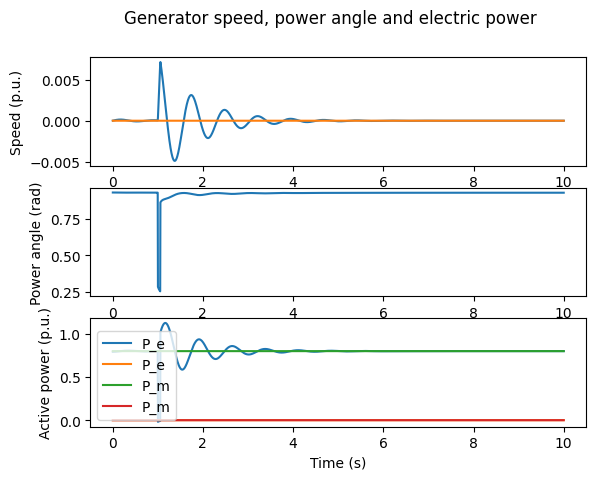

In [18]:

model = load_assignment_model()
ps = dps.PowerSystemModel(model=model)  # Load into a PowerSystemModel object

ps.power_flow()  # Power flow calculation

ps.init_dyn_sim()  # Initialise dynamic variables
x0 = ps.x0.copy()  # Initial states

t = 0
result_dict = defaultdict(list)
t_end = 10  # Simulation time

# Solver
sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x0, t_end, max_step=5e-3)
# endregion

# region Print initial conditions
v_bus_mag = np.abs(ps.v_0)
v_bus_angle = np.angle(ps.v_0)  # In radians
print(f'Voltages (pu): {v_bus_mag}')
print(f'Voltage angles: {v_bus_angle} \n')
print(f'state description: \n {ps.state_desc} \n')
print(f'Initial values on all state variables (G1 and IB) : \n {x0} \n')
# endregion

# region Runtime variables
# Additional plot variables
P_m_stored = []
P_e_stored = []
E_f_stored = []
v_bus = []
I_stored = []

# event_flag1 = True  # Create a different flag for each system event
# endregion

# Simulation loop starts here!
while t < t_end:
    result = sol.step()
    x = sol.y
    v = sol.v
    t = sol.t

    sc_bus_idx = ps.gen['GEN'].bus_idx_red['terminal'][0]

    # Short circuit [1, 1]
    if 1 <= t <= 1.05:
        ps.y_bus_red_mod[1, 1] = 1e6
    else:
        ps.y_bus_red_mod[1, 1] = 0

    # region Store variables
    result_dict['Global', 't'].append(sol.t)
    [result_dict[tuple(desc)].append(state) for desc, state in zip(ps.state_desc, x)]
    # Store additional variables
    P_m_stored.append(ps.gen['GEN'].P_m(x, v).copy())
    P_e_stored.append(ps.gen['GEN'].p_e(x, v).copy())
    E_f_stored.append(ps.gen['GEN'].E_f(x, v).copy())

    I_gen = ps.y_bus_red_full[0, 1] * (v[0] - v[1])
    I_stored.append(np.abs(I_gen))  # Stores magnitude of armature current
    v_bus.append(np.abs(v[0]))  # Stores magnitude of generator terminal voltage
    # endregion

# Convert dict to pandas dataframe
result = pd.DataFrame(result_dict, columns=pd.MultiIndex.from_tuples(result_dict))

# region Plotting
t_stored = result[('Global', 't')]

fig, ax = plt.subplots(3)
fig.suptitle('Generator speed, power angle and electric power')
ax[0].plot(t_stored, result.xs(key='speed', axis='columns', level=1))
ax[1].plot(t_stored, v_bus)
ax[2].plot(t_stored, np.array(P_e_stored), label='P_e')
ax[2].plot(t_stored, np.array(P_m_stored), label='P_m')

ax[0].set_ylabel('Speed (p.u.)')
ax[1].set_ylabel('Power angle (rad)')
ax[2].set_ylabel('Active power (p.u.)')
ax[2].set_xlabel('Time (s)')
plt.legend()
plt.show(block = True)
# endregion
